# Single Dynamic Node Reservoir Computing

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Ridge_regression(S, Y, l):
    '''
    For a linear layer we can solve the weights by a direct method
    If the error function is the mean square error given by
        E = |Y - S * W |^2 + \lambda |W|^2
    where the L2 norm is being applied and the variables are
        Y = [Nsamples x Noutputs] is the desired output
        S = [Nsamples x Nweights] is the input signal
        W = [Nweights x Noutputs] is the weight matrix
    To minimise E we need to solve:
        S^T * S = (S^T * Y  + \lambda I) * W
        W = (S^T*S + \lambda I)^-1 * S^T * Y
    '''
    STS = np.matmul(S.T, S)
    STY = np.matmul(S.T, Y)
    Sdag = np.linalg.pinv(STS + l*np.eye(len(STS)))
    return np.matmul(Sdag, STY)

In [3]:
def MG_func(x, J, gamma, eta, p):
    return eta*(x + gamma*J) / (1 + np.power( x + gamma*J, p))



In [4]:
def MSE (pred, desired):
    return np.mean(np.square(np.subtract(pred,desired)))

In [5]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

In [6]:
def inv_sigmoid(y):
    return - np.log((1.0/y) - 1.0)

In [7]:
class Mackey_Glass_SNR:
    def __init__(self, Nin, Nvirt, Nout, m0=0.1, mask_sparse=1.0, bias=False, act=None, inv_act=None):
        '''
        Nin = input size
        Nvirt = number of virtual nodes
        Nout = output size
        m0 = magnitude of the mask values
        mask_sparse = sparsity factor for mask matrix
        bias = bool flag for using bias
        act = pass an activation function to use
        inv_act = function which applies the inverse of act
        '''
        self.Nin = Nin
        self.Nvirt = Nvirt
        self.Nout = Nout
        self.m0 = m0
        
        # Mask is random matrix of -m0 and m0
        # mask_sparse defines the sparsity level of the input mask
        # i.e 1.0 = full, 0.0 = empty
        self.M = 2*self.m0*(np.random.randint(0,2, (Nvirt,Nin))-0.5)
        #self.M *= 1.0*(np.random.random(size=(Nvirt, Nin)) <= mask_sparse)
        # Empty weight matrix 
        self.W = np.zeros( (Nvirt + int(bias), Nout))
        
        self.use_bias=bias
        
        # Activation and inverse activation functions
        self.f_act = act
        self.f_inv_act = inv_act
        
    def transform(self, u, params):
        '''
        Function to generate the reservoir signal from an input u
        params = dict for various parameters
        '''
        Ns = len(u)
        
        # Unflattens input if it is 1d
        u = u.reshape((Ns, self.Nin))
        
        J = np.zeros((Ns, self.Nvirt))
        
        # expands the signal to include a bias column is req'd
        if self.use_bias:
            S = np.ones((Ns, self.Nvirt+1))
        else:
            S = np.zeros((Ns, self.Nvirt))
        
        # theta = temporal node spacing
        theta = params['theta']
        
        # parameters for the MG function
        Sigma = np.exp(-theta)
        gamma = 0.005
        eta = 0.5
        P = 1
        
        J = np.matmul(u, self.M.T)
        for k in range(Ns):              
            S[k,0] = S[k-1, self.Nvirt-1] * Sigma + (1.0 - Sigma)*MG_func( S[k-1,0], J[k,0], gamma, eta, P)
            for i in range(1,self.Nvirt):
                S[k,i] = S[k,i-1] * Sigma + (1.0 - Sigma)*MG_func( S[k-1,i], J[k,i], gamma, eta, P)   
        return S
    
    def forward(self, S):
        if self.f_act is not None:
            return self.f_act(np.matmul(S, self.W))
        else:
            return np.matmul(S, self.W)
    
    def train(self, u_train, d_train, u_valid, d_valid, params):
        
        S_train = self.transform(u_train, params)
        S_valid = self.transform(u_valid, params)
                
        if self.f_inv_act is not None:
            inv_act_d_train = self.f_inv_act(d_train)
            inv_act_d_valid = self.f_inv_act(d_valid)
        else:
            inv_act_d_train = d_train
            inv_act_d_valid = d_valid
        
        # regularisation parameters to validate over
        lambdas = np.exp(np.linspace(-6,0,num=20))
        lambdas[0] = 0.0
        
        errs = np.zeros(lambdas.shape)
        for i,l in enumerate(lambdas):
            self.W = Ridge_regression(S_train, inv_act_d_train, l)
            valid_pred = self.forward(S_valid)
            errs[i] = MSE(valid_pred, d_valid)
            print(l, MSE(valid_pred, d_valid))
    
        lopt = lambdas[np.argmin(errs)]
        print('Optimal lambda = ', lopt, 'with MSE = ', np.min(errs))
        self.W = Ridge_regression(S_train, d_train, lopt)
        
        

In [8]:
def NARMA10(N):
    u = np.random.random(N+50)*0.5
    y = np.zeros(N+50)
    for k in range(10,N+50):
        y[k] = 0.3*y[k-1] + 0.05*y[k-1]*np.sum(y[k-10:k]) + 1.5*u[k-1]*u[k-10] + 0.1
    return u[50:], y[50:]

In [9]:
Ntrain = 5000
Nvalid = 2000
Ntest = 2000

u, d = NARMA10(Ntrain + Nvalid + Ntest)

utrain = u[:Ntrain]
dtrain = d[:Ntrain]
uvalid = u[Ntrain:Ntrain+Nvalid]
dvalid = d[Ntrain:Ntrain+Nvalid]
utest = u[Ntrain+Nvalid:]
dtest = d[Ntrain+Nvalid:]

In [10]:
net = Mackey_Glass_SNR(1, 40, 1, m0=0.1, mask_sparse=0.5, bias=False)

params = {'theta':0.2}
net.train(utrain, dtrain, uvalid, dvalid, params)

0.0 0.004504467138773107
0.0033992157820051604 0.1616385790461414
0.004661485743271308 0.16390237540551772
0.0063924889528206704 0.16559190798435525
0.008766285528368277 0.16684510688983095
0.012021571336618452 0.16777043991735843
0.01648567993065431 0.16845140145883358
0.02260749740328263 0.16895129800975212
0.031002599892108035 0.1693176140020356
0.04251515251442982 0.16958569096155285
0.058302793946818365 0.16978168588263526
0.07995304217364506 0.16992487979459325
0.10964292652341254 0.17002944354269475
0.15035789770837651 0.17010576995423196
0.20619202825140884 0.17016146924709952
0.28275968979620314 0.17020210775876055
0.3877601032963248 0.17023175352236042
0.5317515301305706 0.1702533777866832
0.729212952525235 0.1702691497727044
1.0 0.17028065266035822
Optimal lambda =  0.0 with MSE =  0.004504467138773107


In [11]:
Stest = net.transform(utest, params)
pred = net.forward(Stest)

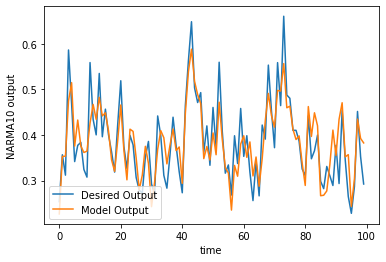

In [12]:
plt.plot(dtest[100:200], label='Desired Output')
plt.plot(pred[100:200], label='Model Output')
plt.legend(loc='lower left')
plt.xlabel('time')
plt.ylabel('NARMA10 output')
plt.show()

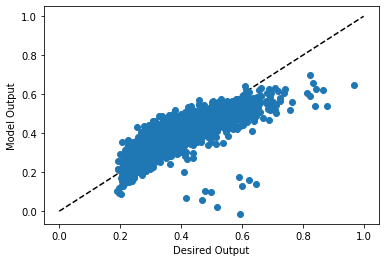

In [13]:
plt.plot(np.linspace(0,1.0),np.linspace(0,1.0), 'k--' )
plt.plot(dtest[:], pred[:], 'o')
plt.xlabel('Desired Output')
plt.ylabel('Model Output')
plt.show()

## My attempt at a single dynamical node reservoir using the Duffing oscillator
This uses a numerical solution of the differential equation compute the time series for the nodes.
Functionality for the feedback loop is incorporated using a lambda function for the input field but it's a bit dodgy so I have omitted it.

In [14]:
from scipy.integrate import solve_ivp

class Duffing:
    def __init__ (self, _alpha, _beta, _delta, _gamma, _omega):
        _l = _delta*0.5
        self.a = _alpha/_l**2
        self.b = _beta/_l**2
        self.l = _l
        self.g = lambda t : _gamma/_l**2
        self.w = _omega/_l
        
    def gradient(self, t, x):
        return [x[1], -0.5*x[1] - self.a*x[0] - self.b*np.power(x[0],3) + self.g(t)*np.cos(self.w*t) ]
    
    def solve(self, t0, tmax, x0, J):
        self.g = J
        sol = solve_ivp( self.gradient, [t0, tmax], x0, dense_output=True)
        return sol
    


In [15]:
class Duffing_Osc_SNR:
    def __init__(self, Nin, Nvirt, Nout, m0=0.1, mask_sparse=1.0, bias=False, act=None, inv_act=None):
        '''
        Nin = input size
        Nvirt = number of virtual nodes
        Nout = output size
        m0 = magnitude of the mask values
        mask_sparse = sparsity factor for mask matrix
        bias = bool flag for using bias
        act = pass an activation function to use
        inv_act = function which applies the inverse of act
        '''
        self.Nin = Nin
        self.Nvirt = Nvirt
        self.Nout = Nout
        self.m0 = m0
        
        # Mask is random matrix of -m0 and m0
        # mask_sparse defines the sparsity level of the input mask
        # i.e 1.0 = full, 0.0 = empty
        self.M = 2*self.m0*(np.random.randint(0,2, (Nvirt,Nin))-0.5)
        self.M *= 1.0*(np.random.random(size=(Nvirt, Nin)) <= mask_sparse)
        
        # Empty weight matrix 
        self.W = np.zeros( (Nvirt + int(bias), Nout))
        
        self.use_bias=bias
        
        # Activation and inverse activation functions
        self.f_act = act
        self.f_inv_act = inv_act
        
    def transform(self, u, params):
        '''
        Function to generate the reservoir signal from an input u
        '''
        Ns = len(u)
        u = u.reshape((Ns,self.Nin))
        J = np.zeros((Ns, self.Nvirt))
        if self.use_bias:
            S = np.ones((Ns, self.Nvirt+1))
        else:
            S = np.zeros((Ns, self.Nvirt))
            
        theta = params['theta']
        #Duffing is a class that contains the gradient function and a solver routine
        dosc = Duffing(-1.0, 1.0, 0.2, 0.01, 1.2)

        # Starting initial values
        t = 0.0
        x = [1.0, 0.0]
        
        J = np.matmul(u, self.M.T)
        for k in range(Ns):             
            for i in range(0, self.Nvirt):
                # The gradient expects a input field that varies with time
                # This is to mimic the feedback loop and so we pass it a lambda fn
                # Without the feedback loop it is the input independent of time
                Jin = lambda t : J[k,i]
                dsol = dosc.solve(t, t+theta, x, Jin)
                t = dsol.t[-1]
                x = [dsol.y[0, -1], dsol.y[1,-1]]
                S[k,i] = x[0]
        return S
    
    def forward(self, S):
        if self.f_act is not None:
            return self.f_act(np.matmul(S, self.W))
        else:
            return np.matmul(S, self.W)
    
    def train(self, u_train, d_train, u_valid, d_valid, params):
        
        S_train = self.transform(u_train, params)
        S_valid = self.transform(u_valid, params)
        
        if self.f_inv_act is not None:
            inv_act_d_train = self.f_inv_act(d_train)
            inv_act_d_valid = self.f_inv_act(d_valid)
        else:
            inv_act_d_train = d_train
            inv_act_d_valid = d_valid
        
        lambdas = np.exp(np.linspace(-6,0,num=20))
        lambdas[0] = 0.0
        errs = np.zeros(lambdas.shape)
        for i,l in enumerate(lambdas):
            self.W = Ridge_regression(S_train, inv_act_d_train, l)
            valid_pred = self.forward(S_valid)
            errs[i] = MSE(valid_pred, d_valid)
            print(l, MSE(valid_pred, d_valid))
    
        lopt = lambdas[np.argmin(errs)]
        print('Optimal lambda = ', lopt, 'with MSE = ', np.min(errs))
        self.W = Ridge_regression(S_train, d_train, lopt)

In [17]:
net2 = Duffing_Osc_SNR(1, 10, 1, bias=False)

params = {'theta':0.2}
net2.train(utrain, dtrain, uvalid, dvalid, params)

0.0 0.014064517013828054
0.0033992157820051604 0.014196331485742095
0.004661485743271308 0.014196233450469394
0.0063924889528206704 0.014196159200978505
0.008766285528368277 0.014196104999079313
0.012021571336618452 0.0141960666038109
0.01648567993065431 0.014196040030913131
0.02260749740328263 0.014196021966888548
0.031002599892108035 0.014196009905914799
0.04251515251442982 0.014196002073693382
0.058302793946818365 0.014195997288636332
0.07995304217364506 0.014195994815479146
0.10964292652341254 0.01419599425031958
0.15035789770837651 0.014195995445306532
0.20619202825140884 0.014195998468834332
0.28275968979620314 0.014196003596100357
0.3877601032963248 0.014196011327366753
0.5317515301305706 0.014196022432545696
0.729212952525235 0.014196038025920512
1.0 0.014196059677546493
Optimal lambda =  0.0 with MSE =  0.014064517013828054


In [18]:
Stest2 = net.transform(utest, params)
pred2 = net.forward(Stest2)

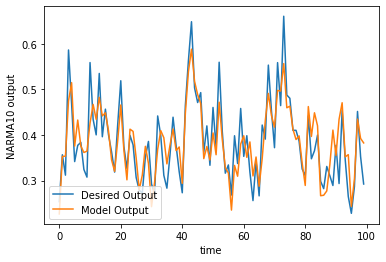

In [19]:
plt.plot(dtest[100:200], label='Desired Output')
plt.plot(pred2[100:200], label='Model Output')
plt.legend(loc='lower left')
plt.xlabel('time')
plt.ylabel('NARMA10 output')
plt.show()

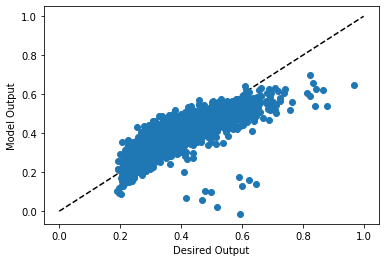

In [20]:
plt.plot(np.linspace(0,1.0),np.linspace(0,1.0), 'k--' )
plt.plot(dtest, pred2, 'o')
plt.xlabel('Desired Output')
plt.ylabel('Model Output')
plt.show()

## Below here is test stuff

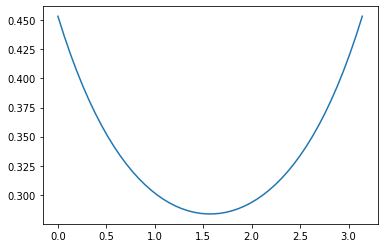

In [16]:
dim = (3)
M = np.zeros(dim)
g = 0.176
alpha = 0.01
Mp = np.array([1.0, 0.0, 0.0])
P = 0.5669
L = 2.0
ep_prime = 0.0

def ep( P, L, M, Mp):
    return (P*L**2)/( (L**2 + 1.) + (L**2 -1.0)*np.dot(M,Mp))

beta = 0

x = np.zeros(50)
y = np.zeros(50)
i = 0
for th in np.linspace(0,np.pi):
    M[0] = np.sin(th)
    M[2] = np.cos(th)
    epsilon = ep(P,L,M,Mp)
    x[i] = th
    y[i] = epsilon
    i += 1
    
plt.plot(x,y)
plt.show()

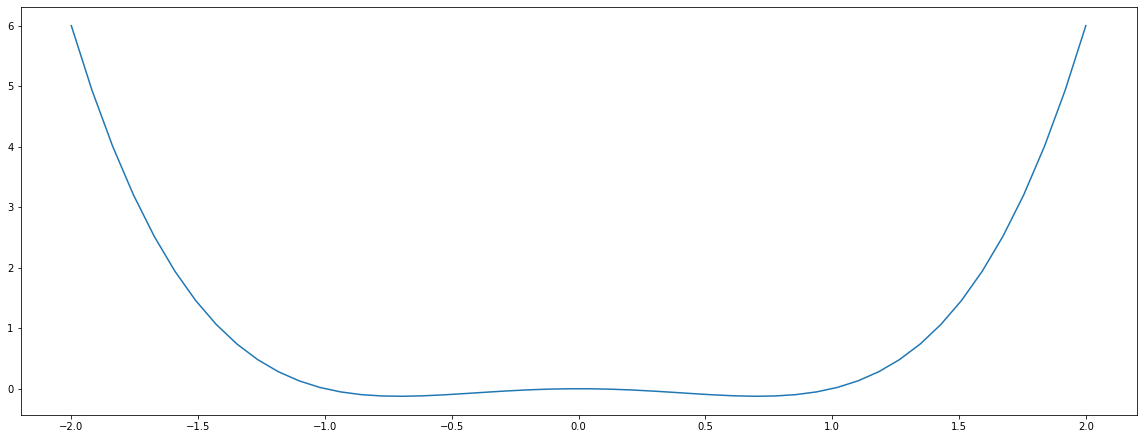

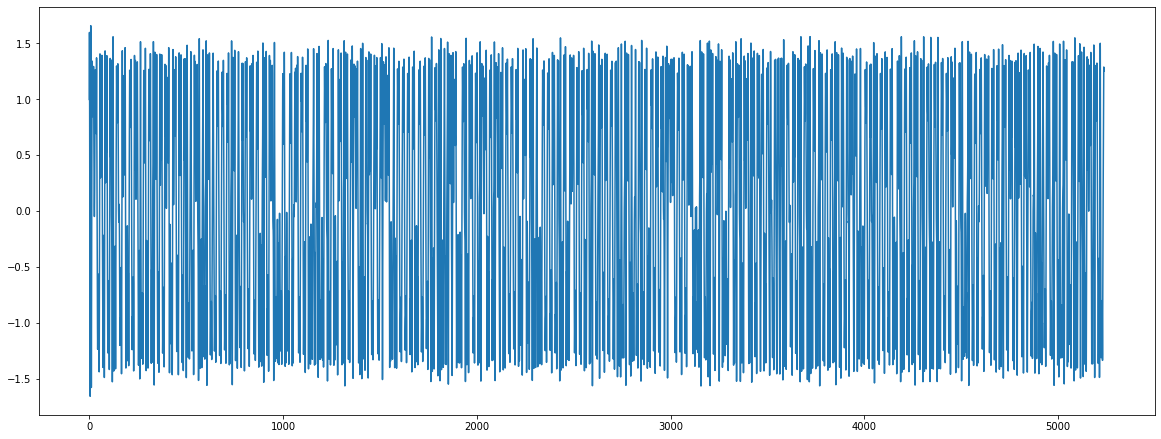

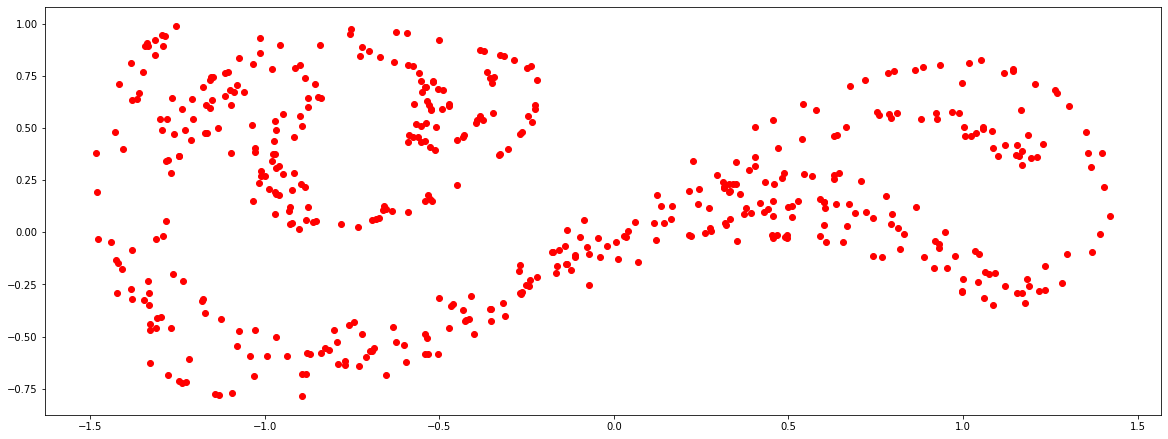

In [12]:
from scipy.integrate import odeint
delta = 0.1
alpha = -1.0
beta = 1.0
gamma = 0.29
w = 1.2

T = 2*np.pi/w

V = lambda x : 0.5*alpha*np.power(x,2) + 0.5*beta*np.power(x,4)

plt.plot(np.linspace(-2,2), V(np.linspace(-2,2)))
plt.show()

def f(x,t):
    return [x[1], -delta*x[1] - alpha*x[0] - beta*x[0]**3 + gamma*np.cos(w*t) ]
Nperiods = 1000
Tmax = T * Nperiods
steps_per_cycle = 100
t = np.linspace(0,Tmax, Nperiods*steps_per_cycle)
x0 = [1.0, 1.0]
sol = odeint(f, x0, t)

PSx = np.array([])
PSy = np.array([])
for i in range(int(len(sol)/2), len(sol)):
    if( np.mod(i,steps_per_cycle) == 0):
        PSx = np.append(PSx, sol[i,0])
        PSy = np.append(PSy, sol[i,1])

plt.plot(t[-0*steps_per_cycle:], sol[-0*steps_per_cycle:,0])
plt.show()
#plt.plot(sol[-10*steps_per_cycle:,0], sol[-10*steps_per_cycle:,1])
plt.plot(PSx, PSy, 'ro')
plt.show()

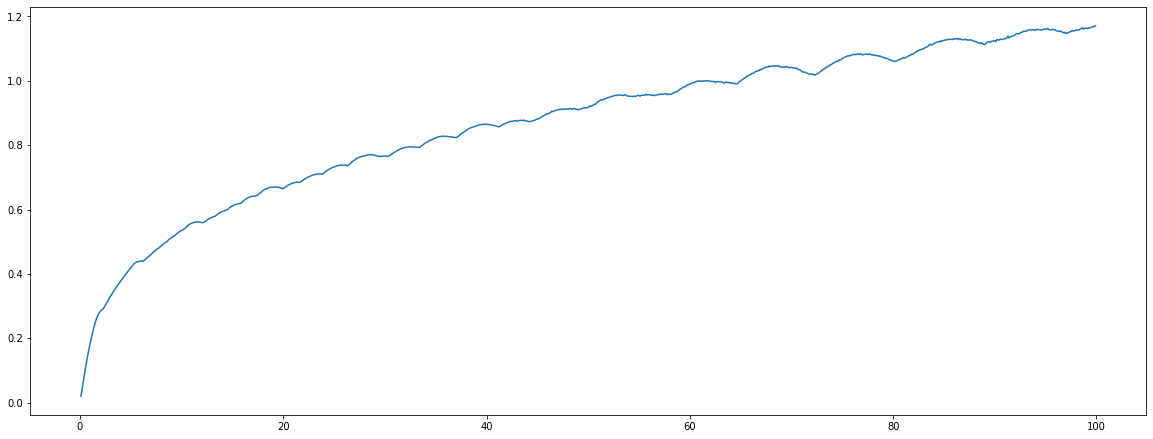

20.0 0.42698320314918203 [0.9558305121215314, 0.7311422024536602]


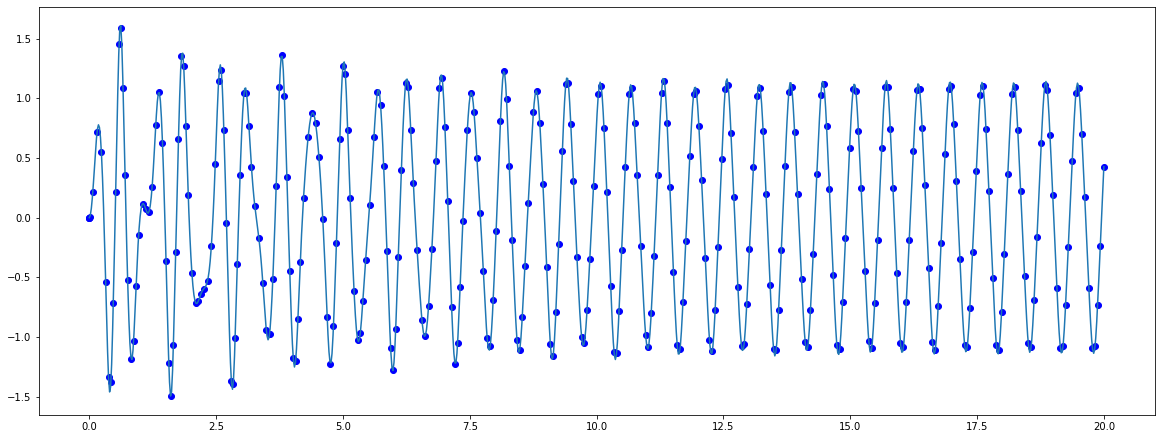

In [64]:
from scipy.integrate import solve_ivp

def NARMA10(N):
    u = np.random.random(N+50)*0.5
    y = np.zeros(N+50)
    for k in range(10,N+50):
        y[k] = 0.3*y[k-1] + 0.05*y[k-1]*np.sum(y[k-10:k]) + 1.5*u[k-1]*u[k-10] + 0.1
    return u[50:], y[50:]

def MG_func(x, J, gamma, eta, p):
    return eta*(x + gamma*J) / (1 + np.power( x + gamma*J, p))

class Duffing:
    def __init__ (self, _alpha, _beta, _delta, _gamma, _omega):
        _l = _delta*0.5
        self.a = _alpha/_l**2
        self.b = _beta/_l**2
        self.l = _l
        self.g = lambda t : _gamma/_l**2
        self.w = _omega/_l
        
    def gradient(self, t, x):
        return [x[1], -0.5*x[1] - self.a*x[0] - self.b*np.power(x[0],3) + self.g(t)*np.cos(self.w*t) ]
    
    def solve(self, t0, tmax, x0, J):
        self.g = J
        sol = solve_ivp( self.gradient, [t0, tmax], x0, dense_output=True)
        return sol
    
Tmax = 20.0
Jin = lambda t : 0.1
dosc = Duffing(1.0, 1.0, 0.2, 0.01, 1.)

amp = []
xmax = []
for i in range(1,1000):
    Jin = lambda t : i*0.1
    dsol = dosc.solve(0.0, Tmax, [0.0, 0.0], Jin)
    amp.append(i*0.1)
    xmax.append(dsol.sol(np.linspace(Tmax*0.5,Tmax,1000))[0,:].max())

plt.plot(amp, xmax)
plt.show()
    
print(dsol.t[-1], dsol.y[0,-1], x0)
fd = dosc.w/(2*np.pi)
fs = fd
plt.plot( dsol.t, dsol.y[0,:], 'bo')
plt.plot( np.linspace(0,Tmax,1000), dsol.sol(np.linspace(0,Tmax,1000))[0,:])
plt.show()

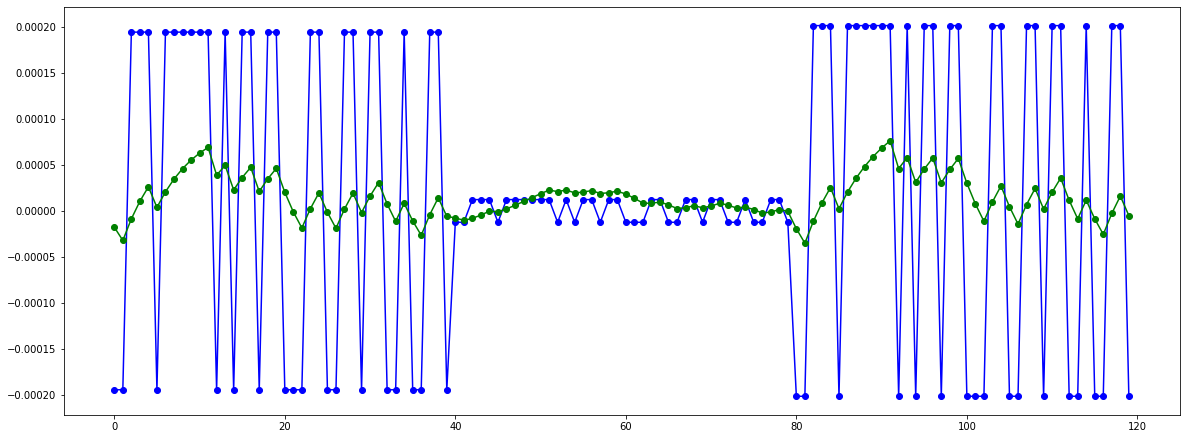

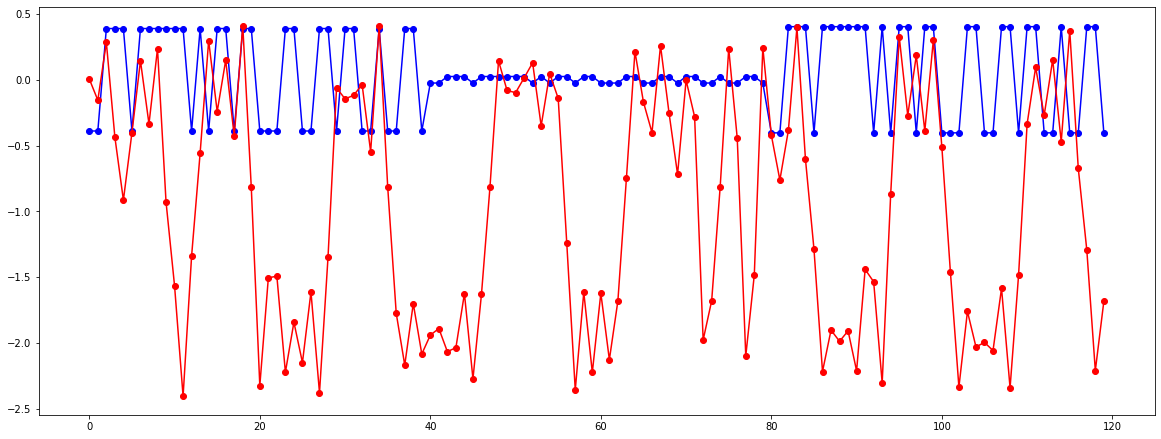

5000 5.320183680093956


5.320183680093956

In [5]:
def MSE(y,d):
    return np.square(np.subtract(y,d)).mean()
class Single_Node_Reservoir:
    def __init__(self, Nin, Nvirt, Nout, theta):
        self.Nin = Nin
        self.Nvirt = Nvirt
        self.Nout = Nout
        self.theta = theta
        self.m0 = 0.1
        self.M = 2*self.m0*(np.random.randint(0,2, (Nvirt,Nin))-0.5)
        self.W = np.zeros( (Nout,Nvirt))
        
    def gen_signal(self, u):
        '''
        Function to generate the reservoir signal from an input u
        '''
        Ns = len(u)
        u = u.reshape((Ns,self.Nin))
        J = np.zeros((self.Nvirt, Ns))
        S = np.zeros((self.Nvirt, Ns))
        S2 = np.zeros((self.Nvirt, Ns))
        dosc = Duffing(-1.0, 1.0, 0.2, 0.01, 1.2)
        
        Sigma = np.exp(-self.theta)
        gamma = 0.005
        eta = 0.5
        P = 1
        
        t = 0.0
        x = [1.0, 0.0]
        for k in range(Ns):
            J[:,k] = np.matmul( self.M, u[k])
            
            for i in range(0, self.Nvirt):
                if(i == 0):
                    Jin = lambda t : 10*(J[i,k]+0.2)
                else:
                    Jin = lambda t : 100*(J[i,k]+0.2) + dsol.sol(t)[0]
                dsol = dosc.solve(t, t+self.theta, x, Jin)
                t = dsol.t[-1]
                x = [dsol.y[0, -1], dsol.y[1,-1]]
                S2[i,k] = x[0]
            
            
            S[0,k] = S[self.Nvirt-1,k-1] * Sigma + (1.0 - Sigma)*MG_func( S[0,k-1], J[0,k], gamma, eta, P)
            for i in range(1,self.Nvirt):
                S[i,k] = S[i-1,k] * Sigma + (1.0 - Sigma)*MG_func( S[i,k-1], J[i,k], gamma, eta, P)

        plt.rcParams['figure.figsize'] = [20,7.5 ]
        plt.plot( gamma*J[:,:3].flatten(order='F'), 'bo-')
        plt.plot( S[:,:3].flatten(order='F'), 'go-')
        plt.show()
        plt.plot( 10*J[:,:3].flatten(order='F'), 'bo-')
        plt.plot( S2[:,:3].flatten(order='F')-1.0, 'ro-')
        plt.show()
        
        return S2
    
    def train(self, u, d):
        S = self.gen_signal(u)
        Sdag = np.linalg.pinv(S)
        self.W = np.transpose(np.matmul(d.T, Sdag))
        y = np.matmul(self.W, S)
        error = np.sqrt(MSE(y,d))/y.std()
        print(len(u), error)
        #plt.plot(np.linspace(0,1.0),np.linspace(0,1.0), 'k--' )
        #plt.plot(y,d,'ro')
        #plt.xlabel('Predicted')
        #plt.ylabel('Exact')
        #plt.show()
        return error
        
        
    def test(self, u, d):
        S = self.gen_signal(u)
        y = np.matmul(self.W, S)
        error = MSE(y,d)
        print('MSE = ', error)
        
        plt.plot(np.linspace(0,1.0),np.linspace(0,1.0), 'k--' )
        plt.plot(y,d,'ro')
        plt.xlabel('Predicted')
        plt.ylabel('Exact')
        plt.show()

  
            
            
        
net = Single_Node_Reservoir(1, 40, 1, 0.2)


u, d = NARMA10(5000)
net.train(u,d)
#err = []
#for i in range(500,10500, 500):
#    err.append(net.train(u[:i],d[:i]))
    
#plt.plot(err, 'bo-')
#plt.show()

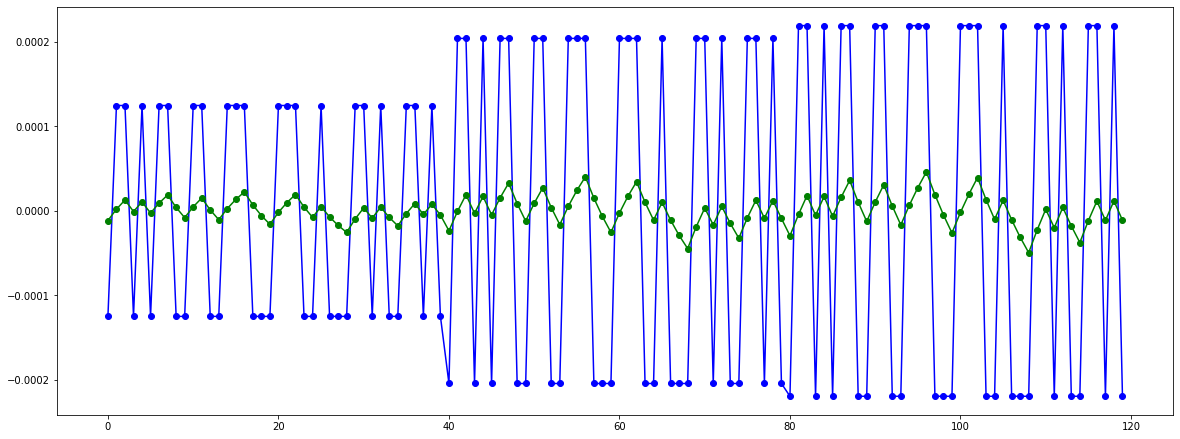

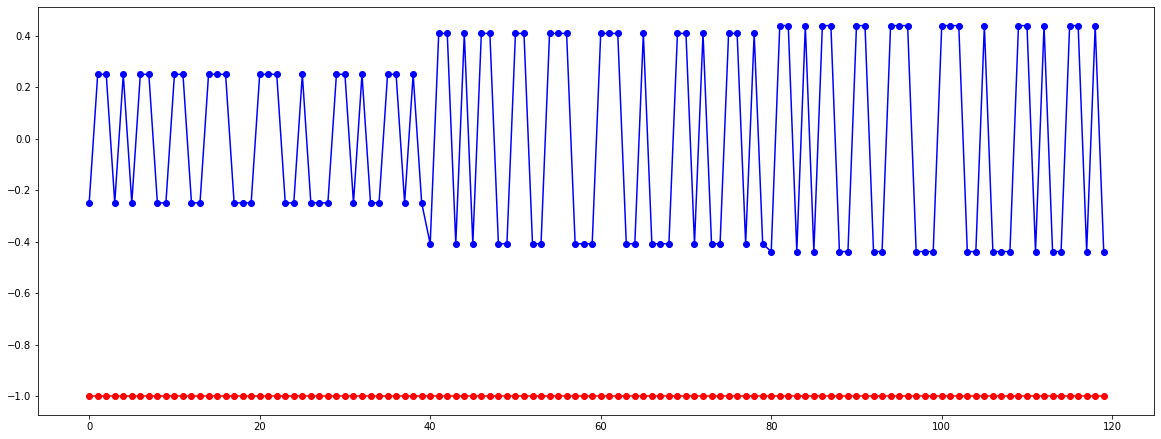

MSE =  0.0030499727838061083


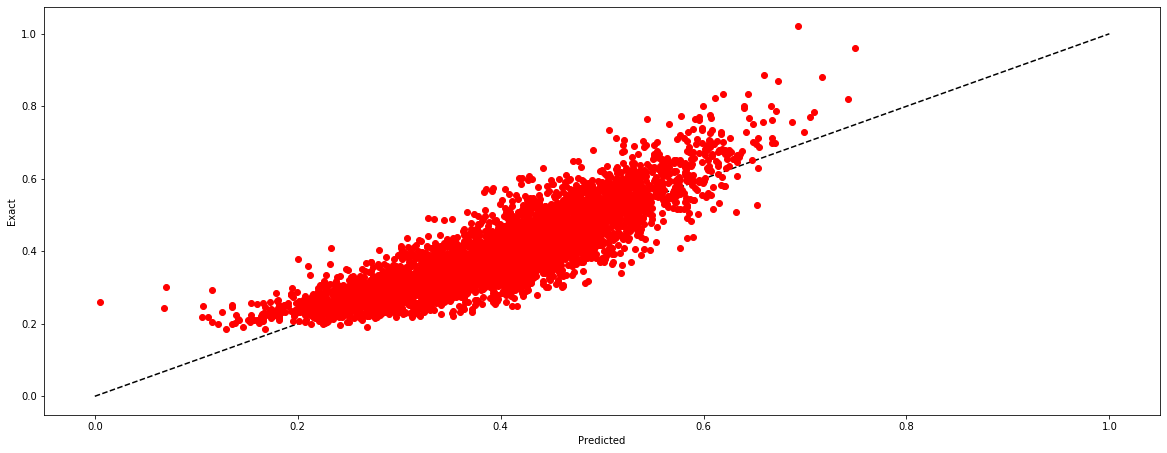

In [277]:
u, d = NARMA10(5000)
net.test(u,d)